# Pysal Access on CyberGIS-Compute

**Authors:** Alexander Michels

This notebook walks through a relatively simple application for [CyberGIS-Compute](https://cybergis.github.io/cybergis-compute-python-sdk/): calculating accessibility to doctors in Chicago, Illinois, U.S. using the [Pysal Access package](https://pysal.org/access/index.html). We will then download the results and calculate correlations between the metrics.

## Table of Contents

* [Data Exploration](#data-explore)
* [Access with CyberGIS-Compute](#compute-job)
* [Analyzing the Outputs](#analysis)

In [26]:
from access import Access, weights, Datasets
import geopandas as gpd
import matplotlib.pyplot as plt
import os
import pandas as pd

In [2]:
# A few useful variables
chfigsize = (8, 10)

<hr id="data-explore" />

## Data Exploration

In this section of the notebook, we will briefly look at Pysal example data before submitting our job using [CyberGIS-Compute](https://cybergis.github.io/cybergis-compute-python-sdk/). Pysal Access has a variety of datasets available:

In [3]:
Datasets.available_datasets()


chi_times: Cost matrix with travel times from each Chicago Census Tract to all others.

chi_doc: Doctor and dentist counts for each Chicago Census Tract.

chi_pop: Population counts for each Chicago Census Tract.

chi_doc_geom: Doctor and dentist counts for each Chicago Census Tract along with geometric representations for Census Tracts.

chi_pop_geom: Population counts for each Chicago Census Tract along with geometric representations for Census Tracts.

chi_euclidean: Euclidean distance cost matrix with distances from each demand Chicago Census Tract to all others.

chi_euclidean_neighbors: Euclidean distance cost matrix with distances from each supply Census Tract to all others.

cook_county_hospitals: Contains data for each hospital location in Cook County including X Y coordinates.

cook_county_hospitals_geom: Contains data for each hospital location in Cook County including X Y coordinates, and geometric points for each hospital.

cook_county_tracts: Geometric representation of 

We will start with the population data:

In [4]:
chicago_pop = Datasets.load_data("chi_pop")
chicago_pop.head()

geoid   pop
0  17031010100  4854
1  17031010201  6450
2  17031010202  2818
3  17031010300  6236
4  17031010400  5042

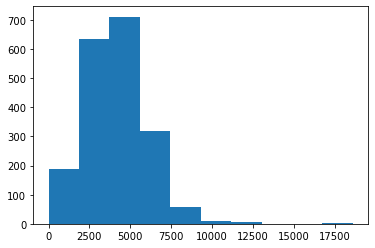

In [5]:
plt.hist(chicago_pop["pop"])
plt.show()

We need to load a geometry to visualization this data. Luckily, that data is also available through pysal/access:

GEO_ID STATE COUNTY   TRACT  NAME   LSAD  CENSUSAREA  \
0  1400000US17031440300    17    031  440300  4403  Tract       0.499   
1  1400000US17031440600    17    031  440600  4406  Tract       0.259   
2  1400000US17031440700    17    031  440700  4407  Tract       0.126   
3  1400000US17031460200    17    031  460200  4602  Tract       0.232   
4  1400000US17031460600    17    031  460600  4606  Tract       0.101   

         geoid                                           geometry  
0  17031440300  POLYGON ((359779.998 563694.900, 359785.854 56...  
1  17031440600  POLYGON ((359797.310 563086.247, 359800.394 56...  
2  17031440700  POLYGON ((360201.128 563098.184, 360402.583 56...  
3  17031460200  POLYGON ((364927.536 564034.757, 365032.657 56...  
4  17031460600  POLYGON ((364641.501 563219.094, 364699.974 56...

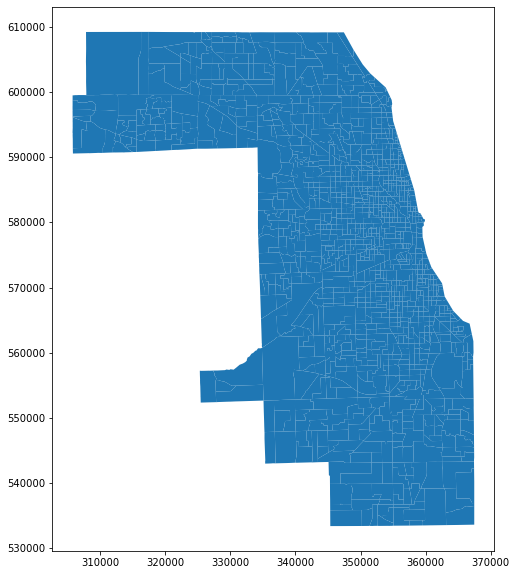

In [6]:
cook_tracts = Datasets.load_data("cook_county_tracts")
cook_tracts.plot(figsize=chfigsize)
cook_tracts.head()

Let's merge the population Dataframe to the census tract GeoDataFrame. They share a field "geoid", so we can use that:

In [7]:
cook_pop = cook_tracts.merge(chicago_pop, on="geoid")
cook_pop.head()

GEO_ID STATE COUNTY   TRACT  NAME   LSAD  CENSUSAREA  \
0  1400000US17031440300    17    031  440300  4403  Tract       0.499   
1  1400000US17031440600    17    031  440600  4406  Tract       0.259   
2  1400000US17031440700    17    031  440700  4407  Tract       0.126   
3  1400000US17031460200    17    031  460200  4602  Tract       0.232   
4  1400000US17031460600    17    031  460600  4606  Tract       0.101   

         geoid                                           geometry   pop  
0  17031440300  POLYGON ((359779.998 563694.900, 359785.854 56...  4757  
1  17031440600  POLYGON ((359797.310 563086.247, 359800.394 56...  2080  
2  17031440700  POLYGON ((360201.128 563098.184, 360402.583 56...  1545  
3  17031460200  POLYGON ((364927.536 564034.757, 365032.657 56...  2385  
4  17031460600  POLYGON ((364641.501 563219.094, 364699.974 56...  1183

Let's visualize and explore our data:

In [8]:
cook_pop.explore(column="pop")

We also need some kind of supply data to use for the accessibility analysis. Let's use the Chicago doctor data with the geometry. According to the description from the `Datasets.available_datasets()` output, this gives us:

> Doctor and dentist counts for each Chicago Census Tract along with geometric representations for Census Tracts.

In [9]:
chi_doc = Datasets.load_data("chi_doc_geom")
chi_doc.head()

geoid  doc  dentist                       geometry
0  17031010100    1        1  POINT (354916.992 594670.505)
1  17031010201    0        1  POINT (354105.876 594088.600)
2  17031010202    4        1  POINT (354650.684 594093.822)
3  17031010300    4        1  POINT (355209.361 594086.149)
4  17031010400    0        2  POINT (355809.748 592808.043)

We will use (and visualize) the doctor information:

In [10]:
chi_doc.explore(column="doc")

Lastly, we need travel-time information. The pysal access package has a Chicago travel-time matrix available:

In [11]:
chi_times = Datasets.load_data('chi_times')
chi_times.head()

origin         dest   cost
0  17093890101  17031010100  91.20
1  17093890101  17031010201  92.82
2  17093890101  17031010202  92.95
3  17093890101  17031010300  89.40
4  17093890101  17031010400  84.97

Let's try plotting this for a single destination. We will plot the source in red and the rest of the census tracts in blue:

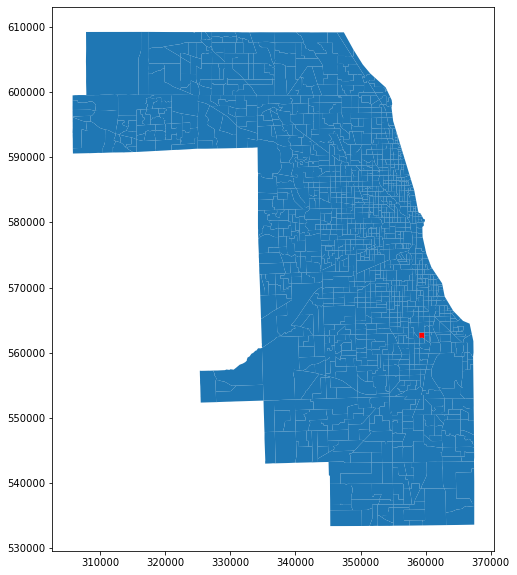

In [12]:
source = 17031440600  # the one destination we will plot costs from
ax = cook_tracts[cook_tracts["geoid"] == source].plot(color="red", figsize=chfigsize)
cook_tracts[~(cook_tracts["geoid"] == source)].plot(ax=ax)
plt.show()

Now, we want to isolate just the costs from the source:

In [13]:
just_source = chi_times[chi_times["origin"] == source]
print(f"There are {len(just_source)} census tracts.")
just_source.head()

There are 2063 census tracts.


origin         dest   cost
1312659  17031440600  17031010100  44.98
1312660  17031440600  17031010201  46.25
1312661  17031440600  17031010202  43.68
1312662  17031440600  17031010300  43.18
1312663  17031440600  17031010400  38.75

...and then merge the costs to a copy of the census tract GeoDataFrame:

In [14]:
dists_from_source = cook_tracts.copy(deep=True)
dists_from_source = dists_from_source.merge(just_source, left_on="geoid", right_on="dest")
dists_from_source.head()

GEO_ID STATE COUNTY   TRACT  NAME   LSAD  CENSUSAREA  \
0  1400000US17031440300    17    031  440300  4403  Tract       0.499   
1  1400000US17031440600    17    031  440600  4406  Tract       0.259   
2  1400000US17031440700    17    031  440700  4407  Tract       0.126   
3  1400000US17031460200    17    031  460200  4602  Tract       0.232   
4  1400000US17031460600    17    031  460600  4606  Tract       0.101   

         geoid                                           geometry  \
0  17031440300  POLYGON ((359779.998 563694.900, 359785.854 56...   
1  17031440600  POLYGON ((359797.310 563086.247, 359800.394 56...   
2  17031440700  POLYGON ((360201.128 563098.184, 360402.583 56...   
3  17031460200  POLYGON ((364927.536 564034.757, 365032.657 56...   
4  17031460600  POLYGON ((364641.501 563219.094, 364699.974 56...   

        origin         dest   cost  
0  17031440600  17031440300   4.97  
1  17031440600  17031440600   0.43  
2  17031440600  17031440700   3.08  
3  17031440600  17031460200  22.38  
4  17031440600  17031460600  19.02

Now we can visualize it!

In [15]:
dists_from_source.explore(column="cost")

<hr id="compute-job" />

## Access with CyberGIS-Compute

Now that we have examined our data, let's run the accessibility job on CyberGIS-Compute. First, we will break down the core components of the job starting with the manifest:

In [16]:
!cat manifest.json

{
    "name": "Pysal Access Example",
    "container": "cybergisx-0.4",
    "pre_processing_stage": "bash install_access.sh",
    "execution_stage": "python ChicagoAccess.py",
    "post_processing_stage": "ls",
    "slurm_input_rules": {
           "time": {
                "max": 30,
                "min": 15,
                "default_value": 20,
                "step": 1,
                "unit": "Minutes"   
            },
            "memory": {
                "max": 4,
                "min": 2,
                "default_value": 4,
                "step": 1,
                "unit": "GB"
            }
    },
    "require_upload_data": false
}


The manifest gives basic information on the job: name, container to run the job in, the steps of the job (pre_processing_stage, executation_stage, and post-processing_stage), etc.

The main steps from the job are:

* "pre_processing_stage": "bash install_access.sh",
* "execution_stage": "python ChicagoAccess.py",
* "post_processing_stage": "ls",

The post_processing_stage just lists the files, so the important parts are the pre_processing_stage and executation_stage. Let's check those out:

In [17]:
!cat install_access.sh

#!/bin/sh
python -m pip install access

This is pretty simple: it just installs the Pysal access package with pip!

Now, we can look at the ChicagoAccess.py which does the actual computation:

In [19]:
!cat ChicagoAccess.py

#!/usr/bin/env python
# coding: utf-8

# In[1]:


import pandas as pd
import geopandas as gpd
from access import Access, weights, Datasets
import os


# In[2]:

RESULTS_FOLDER = os.getenv('result_folder')
print(f"The results folder is: {RESULTS_FOLDER}")

print("Hit the beginning of ChicagoAccess.py")
# Datasets.available_datasets()


# In[3]:


chicago_pop = Datasets.load_data("chi_pop")


# In[4]:


chi_doc = Datasets.load_data("chi_doc_geom")


# In[5]:


chi_times = Datasets.load_data('chi_times')
print("All data loaded successfully")

# In[6]:


A = Access(demand_df            = chicago_pop,
           demand_index         = 'geoid',
           demand_value         = 'pop',
           supply_df            = chi_doc,
           supply_index         = 'geoid',
           supply_value         = 'doc',
           cost_df              = chi_times,
           cost_origin          = 'origin',
           cost_dest            = 'dest',
           cost_name            = 'cost',
           n

The file is a bit long, but let's break it down cell-by-cell:

1. Imports packages
2. Gets the results folder from the environment
3. Loads the population dataset from access
4. Loads the doctor dataset from access
5. Loads the travel-times dataset from access
6. Creates a `pysal.access.Access` object
7. Creates weights objects for our calculations.
8. Calculates a variety of accessibility metrics.
9. Prints the result dataframes's head.
10. Saves the result dataframe to the results path as a CSV.

The file was created from the ChicagoAccess notebook, with some added code (print statements and getting the results folder) after it was exported.

### Running the Job

Now that we've looked over the job, let's run it! The cell below imports the cybergis_compute_client and connects us to our job server:

In [20]:
from cybergis_compute_client import CyberGISCompute

cybergis = CyberGISCompute(url="cgjobsup-dev.cigi.illinois.edu", isJupyter=True, protocol="HTTPS", port=443, suffix="v2")

We will next use the `show_ui()` function to pull up the CyberGIS-Compute interface. From the `Job Templates` dropdown, select `pysal-access` and then click the "Submit Job" button at the bottom:

In [21]:
cybergis.show_ui()

Once the job is submitted, the UI should automatically change tabs to the "Your Job Status". The job takes a few minutes to run because it is installing pysal/access and running the analysis. 

The "job events" section should give you updates on your job though. You should see it being queued (in the queue by our service), registered (sent to the HPC resource), init (started running) and then finally ended.

Once the job ends, go to the "Download Job Result" tab. Under the "select file/f..." dropdown, select "/" (this should be the default).  Then click the "Download" button. This will download the results through [Globus](https://www.globus.org/). When the download finishes, you should see:

>✅ download success!

>please check your data at your root folder under "globus_download_xxxxxxxxxxxxxxx"

You can copy/paste that path, or we can fetch the path from `cybergis.recentDownloadPath`. If for some reason your kernel restarts or the job is no longer showing, you can go to the "Your Jobs" tab and restore it. Under the "exectuableFolder" (the job template) look for "git://pysal-access".

In [23]:
download_path = cybergis.recentDownloadPath
print(f"Our outputs are at {download_path}")

Our outputs are at /home/jovyan/work/globus_download_1655756054oGRMn


Let's `ls` the path to see what is there:

In [24]:
!ls {download_path}

access_result.csv  slurm_log


The `slurm_log` folder has our SLURM job logs:

In [25]:
!ls {download_path}/slurm_log/

job.stderr  job.stdout


Feel free to navigate to this path in the file browser to check out the slurm logs for yourself! If you find the following in `job.stderr`, that is ok, you can safely ignore it:
    
>ModuleCmd_Use.c(231):ERROR:64: Directory 'gnu/openmpi-4.1.2-gnu-4.8.5' not found
WARNING: The directory '/home/jovyan/.cache/pip' or its parent directory is not owned or is not writable by the current user. The cache has been disabled. Check the permissions and owner of that directory. If executing pip with sudo, you may want sudo's -H flag.
/data/keeling/a/cigi-gisolve/.local/lib/python3.7/site-packages/access/fca.py:130: UserWarning: some tracts may be unaccounted for in supply_cost
  warnings.warn("some tracts may be unaccounted for in supply_cost", stacklevel = 1)
access INFO     :: Overwriting fca_doc.


<hr id="analysis" />

## Analyzing the Outputs

Let's load the output and start plotting/analyzing!

In [27]:
result = pd.read_csv(os.path.join(download_path, "access_result.csv"))
result.head()

geoid   pop   gravity_doc   fca_doc  fca60_doc  fca90_doc  2sfca_doc  \
0  17031010100  4854  10618.895243  0.001640   0.001098   0.000922   0.000697   
1  17031010201  6450  10801.211105  0.001536   0.001083   0.000910   0.000754   
2  17031010202  2818  11324.424819  0.001521   0.001071   0.000914   0.000717   
3  17031010300  6236  10535.149629  0.001573   0.001091   0.000916   0.000703   
4  17031010400  5042  10934.394373  0.001551   0.001054   0.000911   0.000743   

   2sfca30_doc  2sfca60_doc  g2sfca_doc  3sfca_doc  raam_doc  raam30_doc  
0     0.000980     0.000688    0.000765   0.001447  0.888102    1.027597  
1     0.001094     0.000751    0.000820   0.001487  0.857214    0.940239  
2     0.001030     0.000719    0.000800   0.001420  0.897102    1.031144  
3     0.001031     0.000709    0.000791   0.001479  0.961906    1.071731  
4     0.000910     0.000788    0.000876   0.001274  1.041687    1.317185

You will see a variety of accessibility metrics! For convenience, I have copied the weights and accessibility cells from the job below:
```
fn30 = weights.step_fn({10 : 1, 20 : 0.68, 30 : 0.22})
fn60 = weights.step_fn({20 : 1, 40 : 0.68, 60 : 0.22})
gaussian = weights.gaussian(20)
gravity = weights.gravity(scale = 60, alpha = -1)

print("Beginning Accessibility calculations")
A.weighted_catchment    (name = "gravity",  weight_fn = gravity)
A.fca_ratio             (name = "fca",      max_cost = 15)
A.fca_ratio             (name = "fca",      max_cost = 30)
A.fca_ratio             (name = "fca60",    max_cost = 60)
A.fca_ratio             (name = "fca90",    max_cost = 90)
A.two_stage_fca         (name = "2sfca",    max_cost = 60)
A.enhanced_two_stage_fca(name = "2sfca30",  weight_fn = fn30)
A.enhanced_two_stage_fca(name = "2sfca60",  weight_fn = fn60)
A.enhanced_two_stage_fca(name = "g2sfca",   weight_fn = gaussian)
A.three_stage_fca       (name = "3sfca")
A.raam(name = "raam", tau = 60)
A.raam(name = "raam30", tau = 30)
```

It will be convenient to merge these outputs to our census tract GeoDataFrame for plotting purposes:

GEO_ID STATE COUNTY   TRACT  NAME   LSAD  CENSUSAREA  \
0  1400000US17031440300    17    031  440300  4403  Tract       0.499   
1  1400000US17031440600    17    031  440600  4406  Tract       0.259   
2  1400000US17031440700    17    031  440700  4407  Tract       0.126   
3  1400000US17031460200    17    031  460200  4602  Tract       0.232   
4  1400000US17031460600    17    031  460600  4606  Tract       0.101   

         geoid                                           geometry   pop  ...  \
0  17031440300  POLYGON ((359779.998 563694.900, 359785.854 56...  4757  ...   
1  17031440600  POLYGON ((359797.310 563086.247, 359800.394 56...  2080  ...   
2  17031440700  POLYGON ((360201.128 563098.184, 360402.583 56...  1545  ...   
3  17031460200  POLYGON ((364927.536 564034.757, 365032.657 56...  2385  ...   
4  17031460600  POLYGON ((364641.501 563219.094, 364699.974 56...  1183  ...   

    fca_doc  fca60_doc  fca90_doc  2sfca_doc  2sfca30_doc  2sfca60_doc  \
0  0.001038   0.000961   0.000898   0.001002     0.001093     0.001167   
1  0.001035   0.000958   0.000898   0.000993     0.001205     0.001162   
2  0.001032   0.000968   0.000900   0.000954     0.000939     0.001082   
3  0.001132   0.001009   0.000917   0.000837     0.000394     0.000753   
4  0.001064   0.000981   0.000910   0.000869     0.000533     0.000840   

   g2sfca_doc  3sfca_doc  raam_doc  raam30_doc  
0    0.001234   0.000782  1.176927    1.354383  
1    0.001264   0.000810  1.252700    1.487897  
2    0.001077   0.000778  1.293301    1.836704  
3    0.000629   0.000614  1.208118    1.410876  
4    0.000730   0.000678  1.221609    1.491280  

[5 rows x 21 columns]

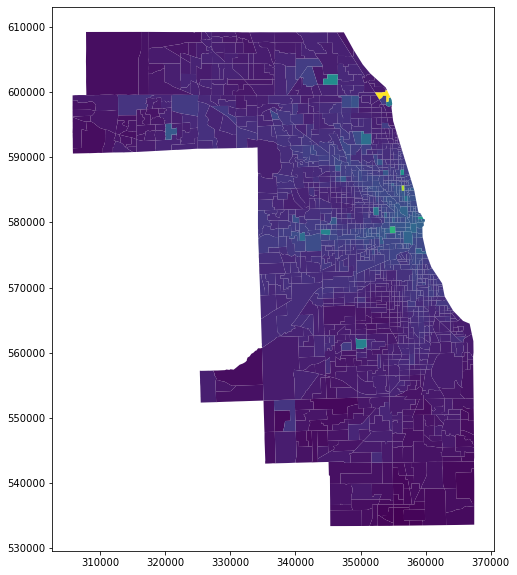

In [29]:
result_gdf = cook_tracts.copy(deep=True)
result_gdf = result_gdf.merge(result, on="geoid")
result_gdf.plot(column="gravity_doc", figsize=chfigsize)
result_gdf.head()

In [33]:
corr = result_gdf[["gravity_doc","fca_doc", "fca60_doc", "fca90_doc", "2sfca_doc", "2sfca30_doc",
                   "2sfca60_doc", "g2sfca_doc", "3sfca_doc", "raam_doc", "raam30_doc"]].corr()

In [36]:
corr.style.background_gradient(cmap='coolwarm')